# Project in TNM098 VT 2018, VAST Challenge MC2 2015

This project will explore data containing phone calls between people in an amusement park. The questions that will be answered are:

1. Identify those IDs that stand out for their large volumes of communication. For each of these IDs
  1. Characterize the communication patterns you see.
  2. Based on these patterns, what do you hypothesize about these IDs?

Please limit your response to no more than 4 images and 300 words.

2. Describe up to 10 communications patterns in the data. Characterize who is communicating, with whom, when and where. If you have more than 10 patterns to report, please prioritize those patterns that are most likely to relate to the crime.

Please limit your response to no more than 10 images and 1000 words.

#### My approach:
To start solving the first problem, I would filter out all communication from the IDs with large volumes. From that I would try to visualize the following:
* With who are these persons are communicating with?
* From what places?
* (Where is the recipient located?)
* What time of the day?
* Do the recipients communicate with each other?
* And more possible properties of the communication data that are relevant


First, start with imports.

In [1]:
import numpy as np
import pandas as pd
import nvd3
import ipywidgets as widgets
from IPython.display import display, HTML
import datetime
import time
import networkx as nx
from nvd3 import stackedAreaChart
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12,12)

data_Fri = pd.read_csv("data/comm-data-Fri.csv")
data_Sat = pd.read_csv("data/comm-data-Sat.csv")
data_Sun = pd.read_csv("data/comm-data-Sun.csv")

data_Concat = pd.concat([data_Fri, data_Sat, data_Sun])

# Get all the timestamps for the x-axis and set counter to zero for all to be 
# able to merge with individual recipients data later
timestamps_fri = pd.Series(0, data_Fri.Timestamp.unique(), name='timestamps_fri')

widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)
#display(w)

loaded nvd3 IPython extension
run nvd3.ipynb.initialize_javascript() to set up the notebook
help(nvd3.ipynb.initialize_javascript) for options


Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

Find out which senders stand out for their large communication volumes.

In [2]:
#Count occurrences for each sender
from_data = data_Concat['from']
to_data = data_Concat['to']
send_counts = from_data.value_counts()
receive_counts = to_data.value_counts()

too_low_senders = send_counts[send_counts <= 3000].index
highest_senders = send_counts.drop(too_low_senders)

too_low_receivers = receive_counts[receive_counts <= 3000].index
# Remove 'external' from receivers
too_low_receivers = too_low_receivers.append(pd.Index(['external']))
highest_receivers = receive_counts.drop(too_low_receivers)

Use nvd3 to construct the plot, and export it to view as html.

In [ ]:
nvd3.ipynb.initialize_javascript(use_remote=True)

chart_type = 'discreteBarChart'
chart = nvd3.discreteBarChart(name="highest_senders", height=700, width=1500)

ydata = highest_receivers.to_list()
xdata = list(highest_receivers.keys())

chart.add_serie(y=ydata, x=xdata)
chart.buildhtml()
chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

## Graph of communication network
Look att the network of communication between the ten biggest senders and their five biggest receivers respectively.
Read the graph as following:

**Size of node:** total amount of communication

**Size of edge:** amount of communication between nodes

In [54]:
###### TAKES LONG TIME! ######
ten_highest_senders = list(highest_receivers.keys())[0:10]
receivers_of_ten_highest_senders = []
for sender in ten_highest_senders:
    #print(type(sender))
    sender_data = data_Concat[data_Concat['from'] == int(sender)]
    to_counts = sender_data['to'].value_counts()
    receivers_of_ten_highest_senders += list(to_counts.keys())[0:5]
    
biggest_sender_and_receivers = receivers_of_ten_highest_senders + ten_highest_senders
unique_biggest_sender_and_receivers = list(set(biggest_sender_and_receivers))
#unique_biggest_sender_and_receivers = [int(x) for x in unique_biggest_sender_and_receivers_strings]
unique_biggest_sender_and_receivers.sort()

# print(unique_biggest_sender_and_receivers) #42 persons in this list

# Filter out rows where the sender is not in the unique list
data_filtered_senders = data_Concat[data_Concat['from'].isin(unique_biggest_sender_and_receivers)]

# Data structure for keeping track of communication:
# Dictionary with senders of dictionaries with its receivers 
# com = {sender1: {receiver1: x, receiver2: y}, sender2: {receiver1: z, receiver3: q}}

print("Going through", len(data_filtered_senders), "rows of data, might take a little while.")
communication_network = {}
for index, row in data_filtered_senders.iterrows():
    sender = row['from']
    receiver = row['to']
    if receiver not in unique_biggest_sender_and_receivers:
        # Only sender should be documented
        continue
        receiver = -1 #'other'
        
    if sender in communication_network:
        if receiver in communication_network[sender]:
            communication_network[sender][receiver] += 1
        else:
            communication_network[sender][int(receiver)] = 1
    else:
        communication_network[sender] = {int(receiver): 1}
        
print("Done! Thanks for waiting.")

Going through 341953 rows of data, might take a little while.
Done! Thanks for waiting.


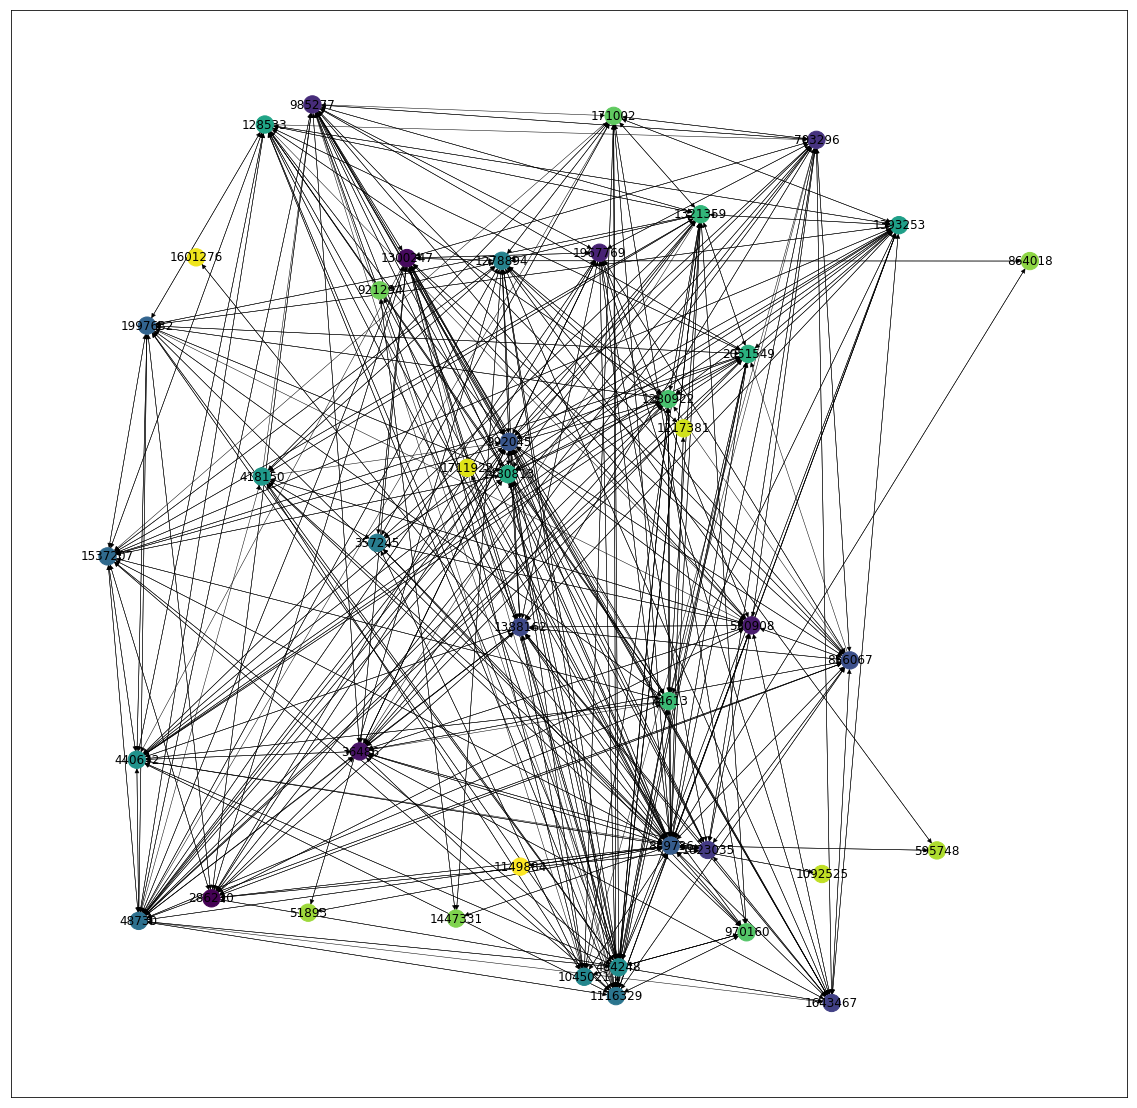

In [55]:
#print(communication_network)
mpl.rcParams['figure.figsize'] = (20,20)

Graph_network = nx.DiGraph()
for sender in communication_network:
    for receiver in communication_network[sender]:
        Graph_network.add_edge(sender, receiver)
        

nx.draw_networkx(Graph_network, 
        pos=nx.random_layout(Graph_network),
        node_color = np.linspace(0,1,len(Graph_network.nodes())),
        width = 0.5,
        with_lables=True
        )
plt.show()

Since 1278894 and 839736 is clearly the biggest senders and receiver, a closer look will be made on its communication patterns.

In [ ]:
# Function for fixing date format in data to be able to compare dates
def convert_to_datetime(str_date):
    #print(str_date)
    date = str_date[0:5] + "0" + str_date[5:]
    return datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")

In [ ]:
# Get all data where 1278894 is the sender
sender_1278894 = data_Concat[data_Concat['from'] == 1278894]

# Get the counts for how many messages are sent by 1278894 each timestamp
timestamp_counts = sender_1278894['Timestamp'].value_counts()
timestamp_counts.sort_index(inplace=True)


In [ ]:

# Get the first and last timestamp where 1278894 send a message
first_time = timestamp_counts.index[0]
last_time = timestamp_counts.index[len(timestamp_counts)-1]

# Get the range of all timestamps where 1278894 sends messages
timestamp_range_1278894 = timestamps_fri[first_time:last_time]

# Join with timestamps to get zeros where there is no communication
timestamp_counts_merged = pd.merge(timestamp_counts, timestamp_range_1278894, how='outer', left_index=True, right_index=True)
# Replace NaN with 0
timestamp_counts_merged.fillna(0, inplace=True)
# Sort based on timestamp
#timestamp_counts_merged.sort_index(inplace=True)
# Remove redundant column with zeros
timestamp_counts_merged.drop('timestamps_fri', axis=1, inplace=True)


### Show when 1278894 is communicating
Plotting it against al timestamps available will give small lines that arare hard to read. By grouping timestamps på bins it will be easier to see when the communication is happening. Communication seems to be happening between 08:00 and 23:59 each day. Let's create 2 bins for each hour of the day.

In [ ]:
timebins = pd.Series(0, index=np.linspace(8,23,31), name='timebins')

def get_halfhour_bin(timestamp):
    if int(timestamp[13:15]) < 30:
        return int(timestamp[10:12])
    else:
        return float(timestamp[10:12]) + 0.5

# Grouping messages to 30-minutes bins
for timestamp in timestamp_counts.index:
    timebins[get_halfhour_bin(timestamp)] += timestamp_counts[timestamp]

In [ ]:
### FOR ALL TIMESTAMPS
# Datetimes on x-axis
"""
chart = stackedAreaChart(name='stackedAreaChart', x_is_date=True, date_format="%d %b %Y", height=700, width=1500)
xdata = [convert_to_datetime(x) for x in list(timestamp_range_1278894.keys())]
xdata = [time.mktime(s.timetuple()) * 1000 for s in xdata]
ydata = timestamp_counts_merged['Timestamp']
"""

### FOR TIMEBINS
from nvd3 import multiBarChart
chart = multiBarChart(name='timebins_communication', height=700, width=1500)
# TODO: fix x-axis to times
xdata = [float(x) for x in timebins.index]
ydata = timebins.to_list()

chart.add_serie(name="Friday", y=ydata, x=xdata)
#chart.add_serie(name="Serie 2", y=ydata2, x=xdata)

chart.buildhtml()

chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

## Biggest receivers of 1278894

In [ ]:
to_counts = sender_1278894['to'].value_counts()
#to_counts.sort_index(inplace=True)

chart_type = 'discreteBarChart'
chart = nvd3.discreteBarChart(name="to_counts", height=700, width=1500)

ydata = to_counts.to_list()
xdata = list(to_counts.keys())

chart.add_serie(y=ydata, x=xdata)
chart.buildhtml()
chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

In [ ]:
# Extract all separate data for all recipients
sender_1278894 = data_Fri[data_Fri['from'] == 1278894]
unique_recipients = sender_1278894.to.unique()
print(len(unique_recipients))

# Get all the timestamps for the x-axis 
# and set counter to zero for all to be 
# able to merge with individual recipients data later
timestamps = pd.Series(0, sender_1278894.Timestamp.unique(), name='ts')

separated_sender_lists = {}
for recipient in unique_recipients:
    # Take only the values for current recipient
    separated_sender_recipient = sender_1278894[sender_1278894['to'] == recipient]
    # Count all the messages for each timestamp
    separated_sender_recipient_counts = separated_sender_recipient['Timestamp'].value_counts()
    # Join with timestamps to get zeros where there is no communication
    separated_sender_lists[recipient] = pd.merge(separated_sender_recipient_counts, timestamp_range_1278894, how='outer', left_index=True, right_index=True)
    # Replace NaN with 0
    separated_sender_lists[recipient].fillna(0, inplace=True)
    # Sort based on timestamp
    separated_sender_lists[recipient].sort_index(inplace=True)
    # Remove redundant column with zeros
    separated_sender_lists[recipient].drop('timestamps_fri', axis=1, inplace=True)

In [ ]:
chart = stackedAreaChart(name='stackedAreaChart2', x_is_date=True, date_format="%d %b %Y", height=3400, width=1500)

# Datetimes on x-axis
xdata = [convert_to_datetime(x) for x in list(timestamps_fri.keys())]
xdata = [time.mktime(s.timetuple()) * 1000 for s in xdata]

extra_serie = {"tooltip": {"y_start": "There is ", "y_end": " min"}}
for recipient in separated_sender_lists:
    chart.add_serie(name=str(recipient), y=separated_sender_lists[recipient]['Timestamp'], x=xdata, extra=extra_serie)
#chart.add_serie(name="Serie 2", y=ydata2, x=xdata, extra=extra_serie)
chart.buildhtml()

chart_html = chart.htmlcontent

# Show the plot
display(HTML(chart_html))

# Klotter

In [ ]:
#import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)         # initiate notebook for offline plot

"""trace0 = go.Scatter(
  x=[1, 2, 3, 4],
  y=[10, 15, 13, 17]
)
trace1 = go.Scatter(
  x=[1, 2, 3, 4],
  y=[16, 5, 11, 9]
)
data = go.Data([trace0, trace1])"""

#plotly.offline.
#iplot(data)               # use plotly.offline.iplot for offline plot

####################################

trace = go.Scatter( 
    x=[1, 2, 2, 1], 
    y=[3, 4, 3, 4], 
    mode='markers',
    marker=dict(size=[100, 100, 100, 100])
)

# Edges
x0 = [1, 2]
y0 = [3, 3]
x1 = [2, 1]
y1 = [4, 4]

fig = go.Figure(
    data=[trace],
    layout=go.Layout(
        annotations = [
            dict(ax=x0[i], ay=y0[i], axref='x', ayref='y',
                x=x1[i], y=y1[i], xref='x', yref='y') for i in range(0, len(x0))
        ]
    )
) 
iplot(fig)

In [ ]:
G_sender_1278894 = nx.DiGraph()
G_sender_1278894.add_node(1278894)
weights = {}
for index, row in sender_1278894.iterrows():
    if row['to'] not in G_sender_1278894:
        G_sender_1278894.add_edge(1278894, row['to'])
        weights[row['to']] = 1
    else:
        weights[row['to']] += 1
        
#print(weights)

In [ ]:
nx.draw(G_sender_1278894,
        node_color = np.linspace(0,1,len(G_sender_1278894.nodes())),
        width = 0.5
        )
plt.show()